# San Francisco Bay Area Bike Share and Weather Exploration
## by BeRT2me

## Preliminary Wrangling

> This document explores data from daily summaries of a bike-sharing system covering the greater San Francisco Bay area.
> I have also chosen to add the Average Temperature, The Precipitation and the Average Windspeed on each day in San Francisco. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import requests
import zipfile
import os

%matplotlib inline

### Load in the Bike Share Data from June 28<sup>th</sup> 2017 to April 30<sup>th</sup> 2019.

In [2]:
# Load in the 2017 Data.
r = requests.get('https://s3.amazonaws.com/baywheels-data/2017-fordgobike-tripdata.csv')
with open('2017-fordgobike-tripdata.csv', 'wb') as data:
    data.write(r.content)
df_2017 = pd.read_csv('2017-fordgobike-tripdata.csv')
os.remove('2017-fordgobike-tripdata.csv')

In [3]:
# Load in the 2018 Data spread across monthly CSVs.
df_2018_months = []
for month in range(1,13):
    r = requests.get('https://s3.amazonaws.com/baywheels-data/2018{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)))
    with open('2018{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)), 'wb') as data:
        data.write(r.content)
    with zipfile.ZipFile('2018{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)), 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('2018{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)))    
    df_2018_months.append(pd.read_csv('2018{}-fordgobike-tripdata.csv'.format(str(month).zfill(2))))
    os.remove('2018{}-fordgobike-tripdata.csv'.format(str(month).zfill(2))) 
df_2018 = pd.concat(df_2018_months, ignore_index=True)

In [4]:
# Load in the 2018 Data spread across monthly CSVs.
df_2019_months = []
for month in range(1,5):
    r = requests.get('https://s3.amazonaws.com/baywheels-data/2019{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)))
    with open('2019{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)), 'wb') as data:
        data.write(r.content)
    with zipfile.ZipFile('2019{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)), 'r') as zip_ref:
        zip_ref.extractall()
    os.remove('2019{}-fordgobike-tripdata.csv.zip'.format(str(month).zfill(2)))    
    df_2019_months.append(pd.read_csv('2019{}-fordgobike-tripdata.csv'.format(str(month).zfill(2))))
    os.remove('2019{}-fordgobike-tripdata.csv'.format(str(month).zfill(2))) 
df_2019 = pd.concat(df_2019_months, ignore_index=True)

In [5]:
# Combine the DataFrames
df = pd.concat([df_2017, df_2018, df_2019], ignore_index=True, sort=False)

In [6]:
# Change Datatypes as necessary 
df.duration_sec = pd.to_timedelta(df.duration_sec, unit='seconds')
df.start_time = pd.to_datetime(df.start_time)
df.end_time = pd.to_datetime(df.end_time)
df.user_type = df.user_type.astype('category')
df.member_gender = df.member_gender.astype('category')
df.start_station_id = df.start_station_id.astype('O')
df.end_station_id = df.end_station_id.astype('O')
df.bike_id = df.end_station_id.astype('O')

In [7]:
# Rename duration column, its units are no longer seconds.
df.rename(columns={'duration_sec': 'duration'}, inplace=True)

In [8]:
# Add a new column with just the date, we'll use this to merge the Weather Data. 
df['date'] = df.start_time.dt.date
df.date = pd.to_datetime(df.date)

### Load in San Francisco Weather Data from June 28<sup>th</sup> 2017 to April 30<sup>th</sup> 2019.

In [9]:
# Load in the San Francisco Weather Data. (Optional since I provide this file)
r = requests.get('https://www.ncei.noaa.gov/orders/cdo/1901573.csv')
with open('1901573.csv', 'wb') as data:
    data.write(r.content)

In [10]:
df_weather = pd.read_csv('1901573.csv', usecols=['DATE', 'PRCP', 'TAVG', 'AWND'])

In [11]:
df_weather = df_weather.groupby('DATE').agg(PRCP=('PRCP', 'max'), TAVG=('TAVG', 'mean'), AWND=('AWND', 'mean')).reset_index()

In [12]:
# Group the various station's data together by date, taking the average if multiple values are present per day. 
df_weather = df_weather.groupby('DATE').max().reset_index()

In [13]:
# Change Datatype of date to datetime. 
df_weather.DATE = pd.to_datetime(df_weather.DATE)

In [14]:
df_weather.rename(columns={'DATE':'date'}, inplace=True)

### Working with the Data

#### Manipulate Bike Share Data to get Daily Summaries

In [15]:
def f(x):
    '''
    Creates a DataFrame with daily summaries of Bike Share rides.
    I only chose to include stats for rides less an hour long so as to not have those outliers. (~2% of the data)
    '''
    x = x[x.duration.astype('timedelta64[m]') < 60]
    d = {}
    d['num_rides'] = x.duration.count()
    d['avg_duration'] = x.duration.mean()
    d['total_duration'] = x.duration.sum()
    d['num_customers'] = x[x.user_type == 'Customer'].user_type.count()
    d['num_subscribers'] = x[x.user_type == 'Subscriber'].user_type.count()
    d['avg_birth_year'] = x.member_birth_year.mean()
    d['male_percentage'] = x[x.member_gender == 'Male'].member_gender.count() / x[(x.member_gender == 'Male')|(x.member_gender == 'Female')].member_gender.count()
    
    return pd.Series(d, index=d.keys())

df2 = df.groupby('date').apply(f).reset_index()

#### Merge the Bike Share and Weather Data

In [16]:
df = df2.merge(df_weather, on='date', how='left')

#### Create some Interesting Categorical Variables

In [17]:
df['rain'] = pd.cut(df.PRCP, bins=[-.1, 4.6, 200], labels=['Not_Rainy', 'Rainy'])
df['day'] = pd.cut(df.date.dt.dayofweek, bins=[-1, 4.5, 7], labels=['weekday', 'weekend'])
labels = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']
df['month'] = pd.cut(df.date.dt.month, bins=12, labels=labels)

#### Save and View the Data

In [18]:
df.to_pickle('daily_summary.pkl')

In [19]:
df = pd.read_pickle('daily_summary.pkl')

In [20]:
df.head()

,date,num_rides,avg_duration,total_duration,num_customers,num_subscribers,avg_birth_year,male_percentage,PRCP,TAVG,AWND,rain,day,month
0,2017-06-28,599,00:10:44.308848,4 days 11:12:21,74,525,1976.666667,0.872928,0.0,15.876923,5.30,Not_Rainy,weekday,June
1,2017-06-29,983,00:10:39.259409,7 days 06:33:12,104,879,1977.188390,0.847850,0.8,15.907692,5.58,Not_Rainy,weekday,June
2,2017-06-30,994,00:10:58.645875,7 days 13:51:34,173,821,1978.010112,0.819413,0.5,15.353846,6.16,Not_Rainy,weekday,June
3,2017-07-01,384,00:17:16.755208,4 days 14:35:14,197,187,1978.861789,0.773109,0.3,15.269231,6.02,Not_Rainy,weekend,July
4,2017-07-02,453,00:19:37.280353,6 days 04:08:28,303,150,1977.497674,0.730233,0.3,17.138462,4.60,Not_Rainy,weekend,July


### What is the structure of your dataset?

> There are 672 days in the dataset with 11 unique variables (Number of rides, Average ride duration, number of customers, number of subscribers, average birth year, male to female ratio, Average Temperature in Celsius, Average Windspeed in meters per second, categorizing the day as rainy or not, categorizing weekend or weekday, and categorizing the month. 

### What is/are the main feature(s) of interest in your dataset?

> I'm most interesting in exploring what weather variables are best for predicting the average ride duration. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I expect that more extreme temperatures or windspeeds will be correlated with shorter average ride durations. I expect that rainy days will have shorter average ride durations. I expect that ride durations will be longer on weekends and during summer months. 

## Univariate Exploration

> With each variable I will Discuss the distribution of the variables and not any unusual points, along with mentioning where, if at all, I perform transformations.

I'll start by looking at the distribution of the main variable of interest, average ride duration.

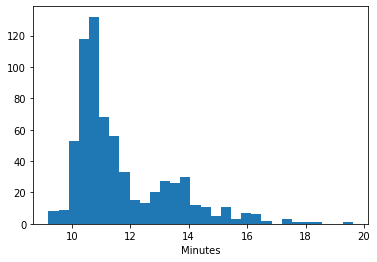

In [21]:
# Start with a simple histogram of the data. 
df['avg_duration_minutes'] = df.avg_duration.astype('timedelta64[s]')/60
plt.hist(df.avg_duration_minutes, bins=30)
plt.xlabel('Minutes');

Average ride duration is roughly bimodal, with one peek around 11 minutes, and another around 13.5 minutes. There are a few outliers greater than about 15 minutes but not greater than 20 minutes. 

Next, I'll look at the distribution of the first predictor variable or interest, average daily temperature.

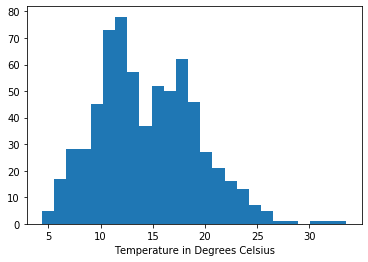

In [22]:
plt.hist(df.TAVG, bins=25)
plt.xlabel('Temperature in Degrees Celsius');

Average daily temperature is bimodal in nature, with one peek between 10 and 15 degrees, and another between 15 and 20 degrees. There are some higher outliers as high as about 30 degrees. 

Next, I'll look at the distribution of average daily windspeed.

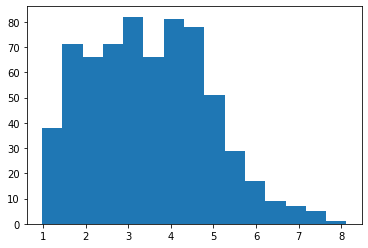

In [23]:
plt.hist(df.AWND, bins=15);

Interestingly, average daily windspeed is somewhat both right-skewed and Uniform in distribution. With roughly equal values between 1 and 5 meters per second with a rightside tail as high as 8 meters per second. 

Next, I'll look at the categorical variables, rainy, day, and month.

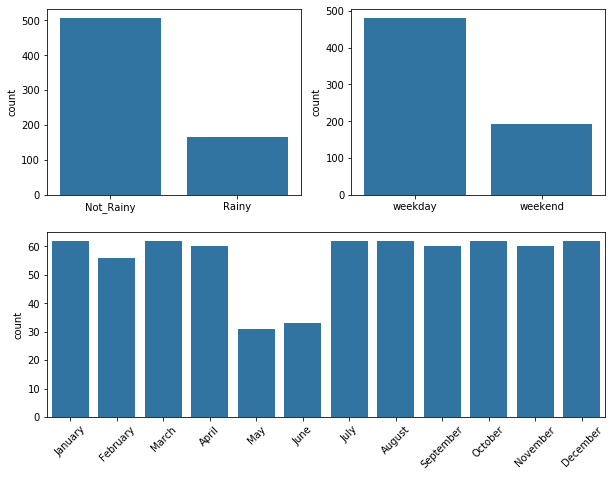

In [24]:
plt.figure(figsize=(10,7.5))
plt.subplot(2,2,1)
plot1 = sb.countplot(df.rain, color='tab:blue')
plot1.set_xlabel('')
plt.subplot(2,2,2)
plot2 = sb.countplot(df.day, color='tab:blue')
plot2.set_xlabel('')
plt.subplot(2,2,(3,4))
plot3 = sb.countplot(df.month, color='tab:blue')
plot3.set_xlabel('');
for item in plot3.get_xticklabels():
    item.set_rotation(45)

There are many more non-rainy days than rainy days, and weekday to weekend looks to be the correct ratio (5:2). We only have one month of data from May and June, which is part of why I feel that studying the number of rides would not be fair for this dataset.

Finally, I'll look at some non-weather related variables, Average Birth Year, and the Male to Female Ratio.

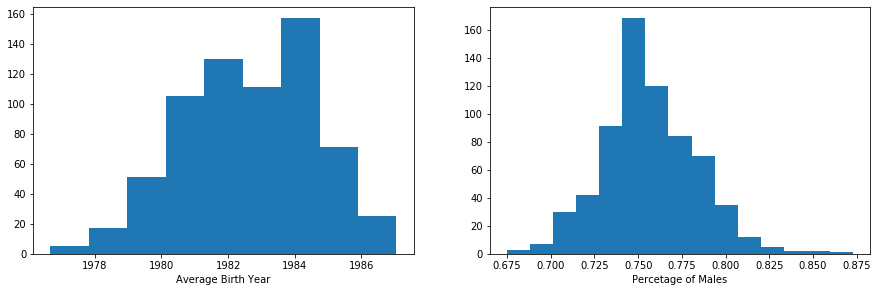

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.hist(df.avg_birth_year, bins=9)
plt.xlabel('Average Birth Year')
plt.subplot(2,2,2)
plot2 = plt.hist(df.male_percentage, bins=15)
plt.xlabel('Percentage of Males');

Average Birth Year and Percentage of males both are fairly normally distributed. Notably, the percentage of males is greater than 50% at around 76%.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> None of the features were especially unusual as to constitute viewing them in a different way (such as logarithmically). I had previously adjusted the data to only reflect rides of less than an hour long so as to remove those outliers, that change represented a removal of less than 2% of the data. 

## Bivariate Exploration
> With each relationship I observe I will talk about what I observed, and how variables varied because of other features. 

> For those relationships between features that are not the main feature of interest, I'll express any interesting relationships that I observe.

First, I'll look at the pairwise correlations present in the numerical features of the data.

In [26]:
numeric_vars = ['avg_duration_minutes', 'TAVG', 'AWND', 'avg_birth_year', 'male_percentage']
categoric_vars = ['rain', 'day', 'month']

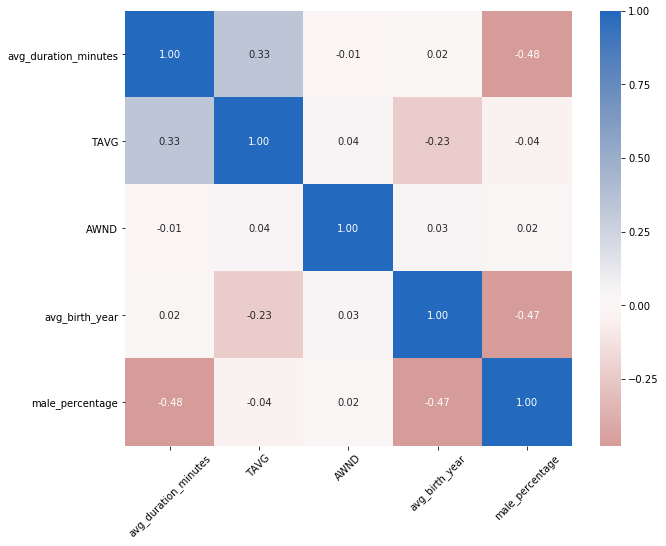

In [27]:
# Correlation Plot
plt.figure(figsize = [10, 8])
plot = sb.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0)
plot.set_ylim(5, 0);
for item in plot.get_xticklabels():
    item.set_rotation(45)

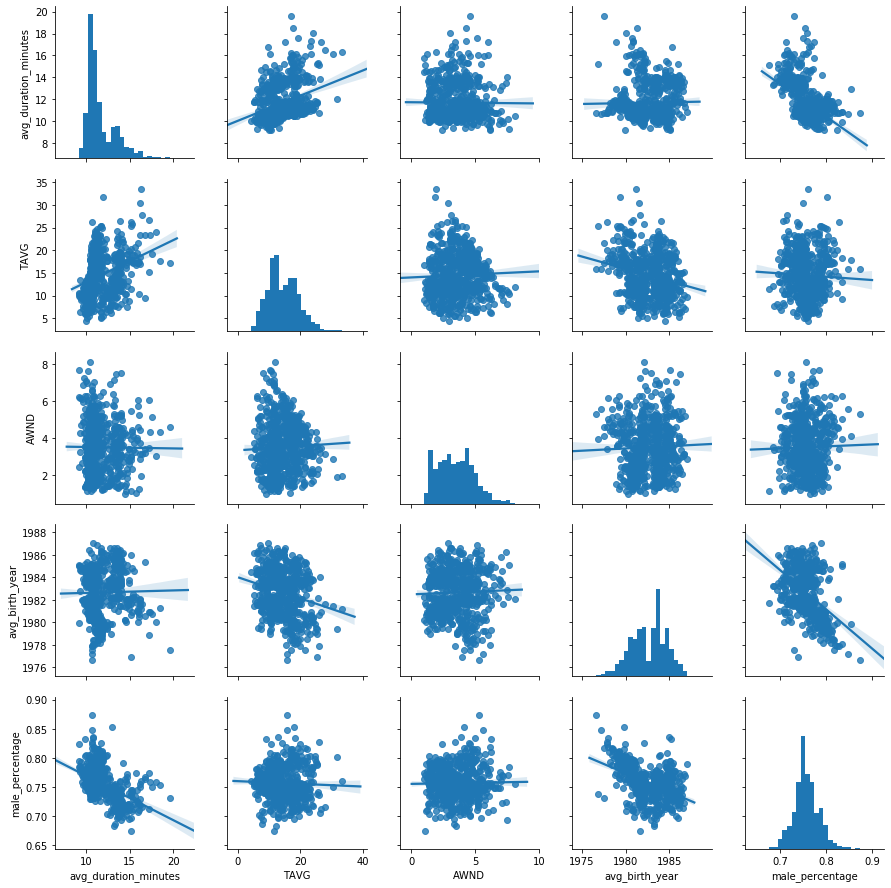

In [28]:
# Plot matrix with lines of best fit on each scatter plot.
g = sb.PairGrid(data = df, vars = numeric_vars,)
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(sb.regplot);

There are two main correlations of interest present in this data in relation to the variable of interest.
- A greater percentage of females is correlated with a longer average ride duration.
- Higher temperatures are correlated with a longer average ride duration.

There are two other interesting correlations not related to the variable of interest.

- A greater percentage of males is correlated with a older average rider. 
- Higher temperatures are correlated with a older average rider. 


Next, I'll look at how the numeric variable vary across the different categories. 

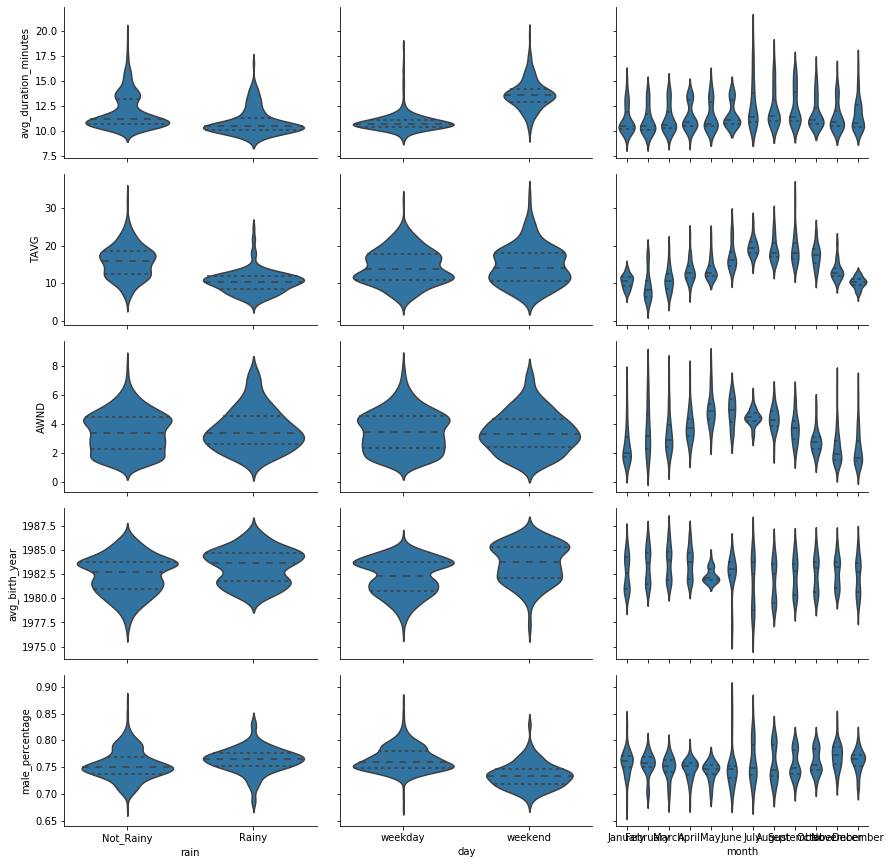

In [29]:
def boxgrid(x, y, **kwargs):
    """ Quick hack for creating box plots with seaborn's PairGrid. """
    sb.violinplot(x, y, color ='tab:blue', inner='quartiles');
g = sb.PairGrid(data = df, y_vars = numeric_vars, x_vars = categoric_vars, height = 3, aspect = 1.5);
g.fig.set_size_inches(12,12)
g.map(boxgrid);

There are some interesting relationships present with the categorical data and the variable of interest.
- Ride duration is lower when it's rainy.
- Ride duration is higher on weekends.
- Ride duration seems to be higher during the summer months.

There are some other interesting relationships present.
- There is a greater percentage of male riders when it's rainy.
- There is a greater percentage of male riders on weekdays.
- There is a lower percentage of male riders during the summer months.
- Riders are older when it's raining.
- Riders are older on the weekends.

Wind and Temperature follow what is expected in nature, they very by month but and whether or not it's raining, but don't change for weekends. 

Finally, we'll look at the relationship between month and rainy days. Month to Weekday/Weekend, and Rain to Weekday/Weekend don't make sense to examine. 

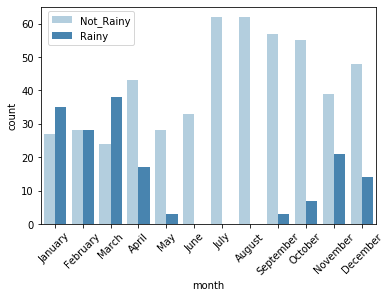

In [30]:
ax = plt.subplot(111)
plot = sb.countplot(df.month, hue=df.rain, palette='Blues')
ax.legend(loc='center', bbox_to_anchor=(.15, .9), ncol=1);
for item in plot.get_xticklabels():
    item.set_rotation(45)

As expected for the region, there are relatively many rainy days November thru April, and relatively few rainy days May thru October.

## Multivariate Exploration

I would like to explore how the binary categorical variables: Rainy/Not Rainy and Weekday/Weekend, play into the relationship between the numeric variables and the variable of interest, Average Trip Duration. 
> After each relationship exploration I will:
- Talk about some of the relationships I observed in that part of the investigation.
- Talk about features that strengthened each other in terms of looking at my feature of interest.

First, I'll look at Rainy vs Not Rainy to see how the relationships differ. 

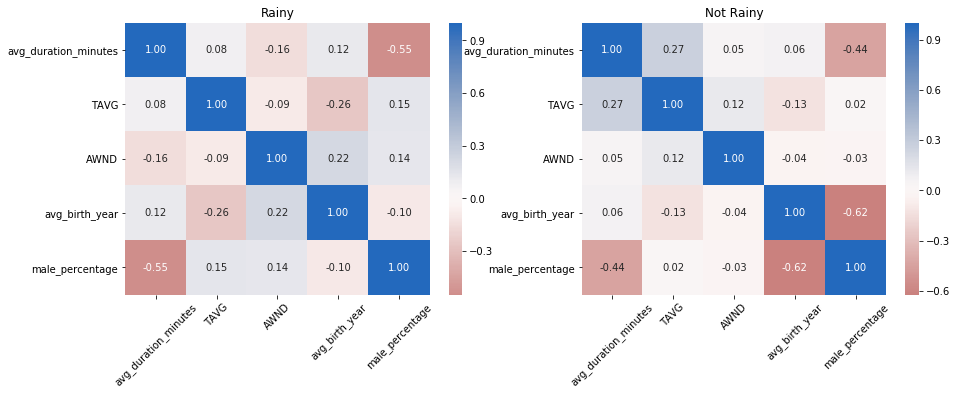

In [31]:
# Correlation Plots Dependent on Rainy/Not Rainy.
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot = sb.heatmap(df[numeric_vars][df.rain == 'Rainy'].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0, ax=ax[0])
plot.set_ylim(5, 0)
plot.set_title('Rainy');
for item in plot.get_xticklabels():
    item.set_rotation(45)
plot2 = sb.heatmap(df[numeric_vars][df.rain == 'Not_Rainy'].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0, ax=ax[1])
plot2.set_ylim(5, 0)
plot2.set_title('Not Rainy');
for item in plot2.get_xticklabels():
    item.set_rotation(45)    

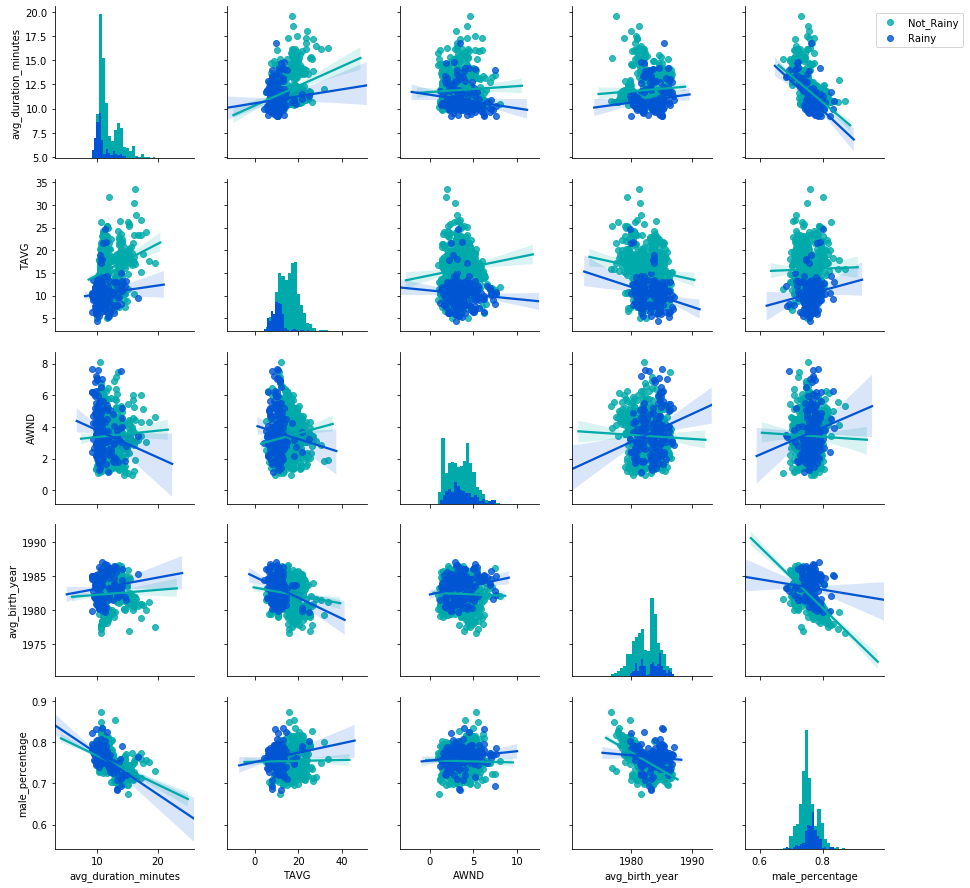

In [32]:
# Plot matrix with a hue of Rainy/Not Rainy, and lines of best fit for each represented on every scatter plot.
g = sb.PairGrid(data = df, vars = numeric_vars, hue='rain', palette='winter_r')
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(sb.regplot)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 4.4));

There are some interesting changes to the correlations with ride duration from adding this third variable:
- Temperature is only correlated with ride duration when it is Not Rainy.
- Increased windspeed is slightly correlated with ride duration when it is Rainy. 

There are some other interesting correlation changes from adding this third variable:
- Lower average age is correlated with higher wind speed averages when it is Rainy.
- Higher temperatures are correlated with a greater percentage of male riders when it is Rainy.
- A greater percentage of male riders is only correlated with on average older riders when it is Not Rainy.

Next, I'll look at Weekday/Weekend to see how relationships differ. 

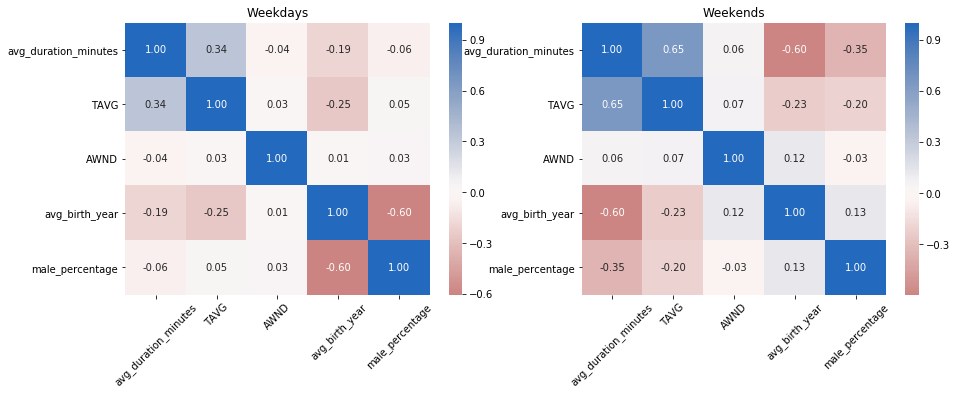

In [33]:
# Correlation Plots Dependent on Weekday/Weekend.
fig, ax = plt.subplots(1,2, figsize=(15,5))
plot = sb.heatmap(df[numeric_vars][df.day == 'weekday'].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0, ax=ax[0])
plot.set_ylim(5, 0)
plot.set_title('Weekdays');
for item in plot.get_xticklabels():
    item.set_rotation(45)
plot2 = sb.heatmap(df[numeric_vars][df.day == 'weekend'].corr(), annot = True, fmt = '.2f', cmap = 'vlag_r', center = 0, ax=ax[1])
plot2.set_ylim(5, 0)
plot2.set_title('Weekends');
for item in plot2.get_xticklabels():
    item.set_rotation(45)    

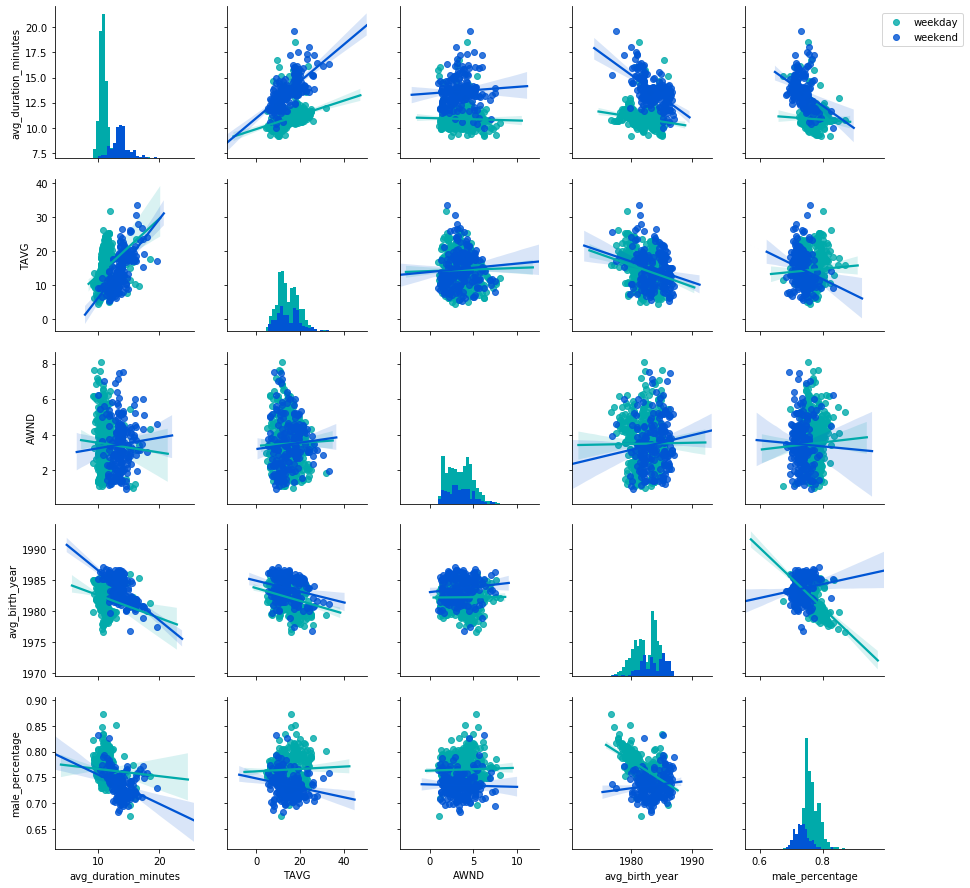

In [34]:
# Plot matrix with a hue of Weekday/Weekend, and lines of best fit for each represented on every scatter plot.
g = sb.PairGrid(data = df, vars = numeric_vars, hue='day', palette='winter_r')
g = g.map_diag(plt.hist, bins = 20)
g.map_offdiag(sb.regplot)
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 4.4));

There are some interesting changes to the correlations with ride duration from adding this third variable:
- The correlation between average temperature and average trip duration is about the same as before on weekdays, however, it is much stronger on weekends.
- A younger average rider is most strongly correlated with shorter average ride durations only on weekends.
- A greater percentage of females is correlated with a longer average ride duration only on weekends.

There are some other interesting correlation changes from adding this third variable:
- A greater percentage of male riders is only correlated with on average older riders on weekdays, otherwise the correlation is slightly the reverse.
- A greater percentage of female riders is only correlated with higher temperatures on the weekend. 

Finally, not only would plotting all the months be difficult to interpret, it would not provide much insight because of how correlated months are with rain. Months with higher rain follow the rainy day trends, and vice versa.  